# [IAPR 2019:][iapr2019] Special project

**Group members:**
    1- first name and last name,
    2- first name and last name,
    3- first name and last name

**Due date:** 30.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Description
Please find the description of this special project via [this link].

[this link]: https://github.com/LTS5/iapr-2019/blob/master/project/special_project_description.pdf

In [1]:
# helper functions
import os
import skimage.io
import xml.etree.ElementTree as ET
import math

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [2]:
data_base_path = os.path.join(os.curdir, 'project-data')
images_folder = 'images/'
annotations_folder = 'annotations/'

train_folder = 'train/'
test_folder = 'test/'
validation_folder = 'validation/'


image_train_path = os.path.join(data_base_path, images_folder+train_folder)
image_test_path = os.path.join(data_base_path, images_folder+test_folder)
image_validation_path = os.path.join(data_base_path, images_folder+validation_folder)

annotation_train_path = os.path.join(data_base_path, annotations_folder+train_folder)
annotation_test_path = os.path.join(data_base_path, annotations_folder+test_folder)
annotation_validation_path = os.path.join(data_base_path, annotations_folder+validation_folder)


with open(data_base_path+'/train.txt') as f:
    names_train = [i.strip('\n') for i in f.readlines()]
    
with open(data_base_path+'/test.txt') as f:
    names_test = [i.strip('\n') for i in f.readlines()]

with open(data_base_path+'/validation.txt') as f:
    names_validation = [i.strip('\n') for i in f.readlines()]

image_train_filenames = [os.path.join(image_train_path, name) + '.jpg' for name in names_train]
image_test_filenames = [os.path.join(image_test_path, name) + '.jpg' for name in names_test]
image_validation_filenames = [os.path.join(image_validation_path, name) + '.jpg' for name in names_validation]

In [3]:
# load annotations and images
annotations_train = [parse_file(os.path.join(annotation_train_path, name) + '.xml') for name in names_train]
annotations_test = [parse_file(os.path.join(annotation_test_path, name) + '.xml') for name in names_test]
annotations_validation = [parse_file(os.path.join(annotation_validation_path, name) + '.xml') for name in names_validation]

image_train = skimage.io.imread_collection(image_train_filenames)
image_test = skimage.io.imread_collection(image_test_filenames)
image_validation = skimage.io.imread_collection(image_validation_filenames)


In [4]:
print('Number of images/annotations in train: ', len(image_train), len(annotations_train))
print('Number of images/annotations in test: ', len(image_test), len(annotations_test))
print('Number of images/annotations in validation: ', len(image_validation), len(annotations_validation))

Number of images/annotations in train:  800 800
Number of images/annotations in test:  50 50
Number of images/annotations in validation:  150 150


The cell below, plots the test images with the annotations of ground truth.

In [5]:
import matplotlib.patches as patches
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import morphology
from skimage.morphology import square
from scipy.ndimage.morphology import binary_fill_holes
from scipy.ndimage import morphology
import numpy as np
import matplotlib.patches as mpatches

# Plotting the thresholded image collection
fig, axes = plt.subplots(25, 2, figsize=(12, 200))
for ax, im , annotations in zip(axes.ravel(), image_test, annotations_test):
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
            linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect)
    ax.imshow(im,cmap='ocean')
    ax.axis('off')
plt.show()

<Figure size 1200x20000 with 50 Axes>

## Part 1: Finding varroas by segmentation
Add your implementation for ''**detect_by_segmentation**'' function. Please make sure the input and output follows the mentioned format.

The first Implemented method is segmentation. The code has 5 main parts in this method, first finding the areas which are a part of the background for sure. Second, improving the lightness of image based on the HSV version. Third, performing adaptive thresholding on the grayscale images. After that, a set of morphological operations have been done as the 4th step. And finally, a filtering by average size has been done. 

In [6]:
def detect_by_segmentation(input_image):

    #Finding the areas that are a part of background for sure
    
    #Thresholding on the grayscale image
    gray = cv2.cvtColor(input_image,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # Removing the noise
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    
    # Finding the big, surely background areas 
    sure_bg = cv2.dilate(opening,kernel,iterations=3)
    sure_bg = skimage.morphology.remove_small_objects(sure_bg.astype(bool), min_size=8000)
    sure_bg= morphology.binary_fill_holes(sure_bg).astype(np.uint8)
    
    #---------------------
    
    #Perfrmoing the main segementation
       
    # Transforming the image to HSV format to find the mean of lightness of image
    image_hsv = cv2.cvtColor(input_image,cv2.COLOR_RGB2HSV)
    mean_hsv = np.mean(image_hsv[:,:,2])
    
    # Improving the lightness based on the mean lightness of the image (if it is not decent)
    if (mean_hsv <= 110):
        image_hsv[:,:,2] = image_hsv[:,:,2] *1.2
    elif(mean_hsv > 150):
        image_hsv[:,:,2] = image_hsv[:,:,2] *0.8
    
    # Performing an adaptive thresholding on the grayscale version of image
    image_rgb = cv2.cvtColor(image_hsv,cv2.COLOR_HSV2RGB)
    image_grayscale = cv2.cvtColor(image_rgb,cv2.COLOR_RGB2GRAY)
    image_thresholded= ~(cv2.adaptiveThreshold(image_grayscale,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,15,3))
    
    # Performing different morphological operations to improve the result
    image_processed = skimage.morphology.remove_small_objects(image_thresholded.astype(bool), min_size=220)
    image_processed = skimage.morphology.binary_opening(image_processed.astype(bool), selem = square(4), out=None)
    image_processed = skimage.morphology.binary_closing(image_processed.astype(bool), selem = square(5), out=None)
    image_processed = skimage.morphology.binary_erosion(image_processed.astype(bool), selem=np.ones([6,6]))
    image_processed = skimage.morphology.binary_dilation(image_processed.astype(bool), selem=np.ones([6,6]))
    image_processed = skimage.morphology.remove_small_objects(image_processed.astype(bool), min_size=310)
    image_processed = skimage.morphology.binary_opening(image_processed, selem = square(6), out=None)
    image_processed = morphology.binary_fill_holes(image_processed).astype(np.uint8)
    
    #Removing the sure background areas
    image_processed[sure_bg>0]=0
    image_processed_1 = skimage.morphology.remove_small_objects(image_processed.astype(bool), min_size=710)
    image_processed_2 = skimage.morphology.remove_small_objects(image_processed.astype(bool), min_size=100)
    image_processed_2[image_processed_1>0]=0
    
    #Labeling the image
    labels=skimage.measure.label(image_processed_2,neighbors=8,background=0,return_num=False)
    
    #Finding the main output set with a size filtering
    rg_area=0
    rg_n=1
    for region_labeled in skimage.measure.regionprops(labels):
        rg_area=rg_area+region_labeled.area 
        rg_n=rg_n+1
    rg_avg=rg_area/rg_n  
    label_outs=[]
    for region_labeled in skimage.measure.regionprops(labels):
        if region_labeled.area >= (rg_avg-10) and region_labeled.area <=(rg_avg+200):
            y_min, x_min, y_max, x_max = region_labeled.bbox
            label_out=[x_min, y_min, x_max - x_min, y_max - y_min]
            label_outs.append(label_out)
            
    return label_outs

#Finding the labels for the whole test set
ic_labeled=skimage.io.ImageCollection(image_test,load_func=detect_by_segmentation)


Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

The function below, shows the main code has been applied to find the precision, recall, and f1-score for each image. It recieves the labeles from the implemented method, the image set, and the IoU threshold and finds the precision, recall, and f1-score. It also plots the bounding boxes on the image and when they show the true positive, the color will become green.

----  T=0.3 -----


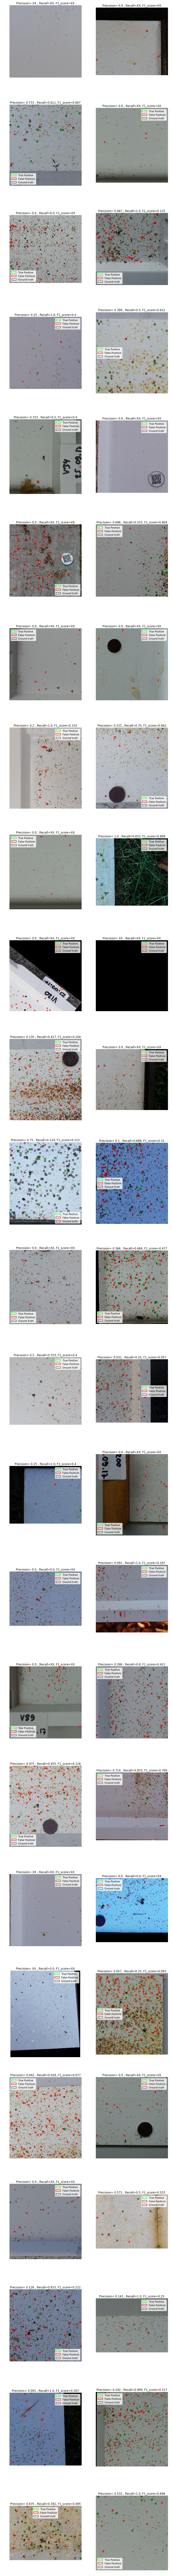

In [7]:
def distance_finder(x_1,y_1,x_2,y_2):  
    dist = np.sqrt((x_2 - x_1)**2 + (y_2 - y_1)**2)  
    return dist 

# Finds the intersection over union of two rectangles
def intersection_over_union(rect_1, rect_2):
    x_1 = max(rect_1[0], rect_2[0])
    y_1 = max(rect_1[1], rect_2[1])
    x_2 = min(rect_1[2], rect_2[2])
    y_2 = min(rect_1[3], rect_2[3])

    rect_1_area = (rect_1[2] - rect_1[0] +1) * (rect_1[3] - rect_1[1] +1)
    rect_2_area = (rect_2[2] - rect_2[0] +1) * (rect_2[3] - rect_2[1] +1)
    intersection = max(0, x_2 - x_1 +1) * max(0, y_2 - y_1 +1)
    IoU = intersection / float(rect_1_area + rect_2_area - intersection)
    
    return IoU

def Precision_Recall_F1_score(T,ic_labeled,image_test):
    
    fig, axes = plt.subplots(25, 2, figsize=(12, 200))
    for ax, im, ig , annotations  in zip(axes.ravel(),image_test,ic_labeled, annotations_test):
        
        # Initializing the variables
        dist=[]
        true_positive=0
        false_positive=0

        for region_labeled in ig:

            dist=[]
            IoU=[]

            # Checking each labeled region with all the ground truth regions 
            # and find the one with the minimum distance
            if len(annotations)>0:
                for anno in annotations:
                    dist.append(distance_finder(region_labeled[0]+region_labeled[2]/2.,region_labeled[1]+region_labeled[3]/2.,(anno['bbox'][0]+(anno['bbox'][2])/2),(anno['bbox'][1]+(anno['bbox'][3])/2)))
                least_distance=np.argmin(dist)

                # Finding the intersection over union between the labeled area and the ground
                # truth with the least distance
                bbox_region_truth=annotations[least_distance]
                IoU=intersection_over_union((bbox_region_truth['bbox'][0],bbox_region_truth['bbox'][1],bbox_region_truth['bbox'][0]+bbox_region_truth['bbox'][2],bbox_region_truth['bbox'][1]+bbox_region_truth['bbox'][3]),(region_labeled[0],region_labeled[1],region_labeled[0]+region_labeled[2],region_labeled[1]+region_labeled[3]))
                del dist

                # Patching the true positives with green rectangles and numbers
                if (IoU>=T):
                    x_min, x_max, y_min, y_max = [region_labeled[0],region_labeled[0]+region_labeled[2],region_labeled[1],region_labeled[1]+region_labeled[3]]
                    rect_detection = mpatches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,fill=False, edgecolor='lime', linewidth=1.5)
                    line_1=ax.add_patch(rect_detection)
                    #Counting the number of false positives
                    true_positive=true_positive+1

                # Patching the false positives with red rectangles and numbers
                else:
                    x_min, x_max, y_min, y_max = [region_labeled[0],region_labeled[0]+region_labeled[2],region_labeled[1],region_labeled[1]+region_labeled[3]]
                    rect_detection = mpatches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,fill=False, edgecolor='red', linewidth=1.5)
                    line_2=ax.add_patch(rect_detection)
                    #Counting the number of false positives
                    false_positive=false_positive+1
            else:
                true_positive=0.
                false_positive=np.shape(ig)[0]
                x_min, x_max, y_min, y_max = [region_labeled[0],region_labeled[0]+region_labeled[2],region_labeled[1],region_labeled[1]+region_labeled[3]]
                rect_detection = mpatches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,fill=False, edgecolor='red', linewidth=1.5)
                line_2=ax.add_patch(rect_detection)
        ax.imshow(im,cmap='ocean')

        # Finding the number of false negatives for each image
        false_negative=np.size(annotations)-true_positive

        # Finding the precision and recall for each of the figures
        if (false_positive+true_positive)==0:
            precision='XX'
        else:
            precision=true_positive/(false_positive+true_positive)
        if (false_negative+true_positive)==0:
            recall='XX'
        else:
            recall=true_positive/(false_negative+true_positive)

        # Finding the precision and recall for each of the figures
        # If we have a zero in the denominator of the F1_score function, the output will be XX
        if precision=='XX' or recall=='XX' or precision==0 or recall==0:
            f1_score='XX'
        else:
            f1_score=(2*precision*recall)/(precision+recall)

        #Drawing the rectangles for the ground truth    
        for anno in annotations:
                rect_ground_truth = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='black',facecolor='none')
                line_3=ax.add_patch(rect_ground_truth) 


        # Adding the titles that contain the precision, recall and F1-score
        if (f1_score=='XX' or recall=='XX' or precision=='XX'):
            ax.set_title("Precision= %s , Recall=%s, F1_score=%s" % (precision, recall, f1_score))
        else:
            ax.set_title("Precision= %s , Recall=%s, F1_score=%s" % (np.round(precision,3), np.round(recall,3), np.round(f1_score,3)))
        # Adding the legends
        if 'line_1' in locals() and 'line_2' in locals() and 'line_3' in locals():
            ax.legend((line_1,line_2,line_3), ('True Positive','False Positivie','Ground truth'))
        elif 'line_3' in locals() and 'line_1' in locals():
            ax.legend((line_1, line_3), ('True Positive','Ground truth'))
        ax.axis('off') 
        ax.imshow(im,cmap='ocean')
        ax.axis('off')
            
    plt.show()
    return IoU

T=0.3
print("----  T=%s -----" % (T) )
P=Precision_Recall_F1_score(T,ic_labeled,image_test)

## Part 2: Implement your first detector

Write your function(s) for the second part. Feel free to change the name of the function and add your additional functions, but please make sure their input and output follows the mentioned format.

In [8]:
def detect_by_method_1(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    #Your code

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [9]:
#Your code

## Part 3: Using MLP and CNNs

Add your implementation for the thrid part. Feel free to add your desirable functions, but please make sure you have proper functions for the final detection, where their input and output follows the same format as the previous parts.

In [10]:
#Your code

## Challenge

You can generate a json submission file by using the function ''**generate_pred_json**''. This prediction file can be uploaded online for evaluation (Please refer to section 3 of the project description for more details).

In [ ]:
import numpy as np
import json

def generate_pred_json(data, tag='baseline'):
    '''
    Input
    - data: Is a dictionary d, such that:
          d = { 
              "ID_1": [], 
              "ID_2": [[x_21, y_21, w_21, h_21], [x_22, y_22, w_22, h_22]], 
              ... 
              "ID_i": [[x_i1, y_i1, w_i1, h_i1], ..., [x_iJ, y_iJ, w_iJ, h_iJ]],
              ... 
              "ID_N": [[x_N1, y_N1, w_N1, h_N1]],
          }
          where ID is the string id of the image (e.i. 5a05e86fa07d56baef59b1cb_32.00px_1) and the value the Kx4 
          array of intergers for the K predicted bounding boxes (e.g. [[170, 120, 15, 15]])
    - tag: (optional) string that will be added to the name of the json file.
    Output
      Create a json file, "prediction_[tag].json", conatining the prediction to EvalAI format.
    '''
    unvalid_key = []
    _data = data.copy()
    for key, value in _data.items():
        try:
            # Try to convert to numpy array and cast as closest int
            print(key)
            v = np.around(np.array(value)).astype(int)
            # Check is it is a 2d array with 4 columns (x,y,w,h)
            if v.ndim != 2 or v.shape[1] != 4:
                unvalid_key.append(key)
            # Id must be a string
            if not isinstance(key, str):
                unvalid_key.append(key)
            _data[key] = v.tolist()
        # Deal with not consistant array size and empty predictions
        except (ValueError, TypeError):
            unvalid_key.append(key)
    # Remove unvalid key from dictionnary
    for key in unvalid_key: del _data[key]
    
    with open('prediction_{}.json'.format(tag), 'w') as outfile:
        json.dump(_data, outfile)

professions_dict = dict(zip(names_test, ic_labeled))
generate_pred_json(professions_dict,tag='group_2_segmentation')

In [12]:
#Your code